In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/imagenet-50"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24392 files belonging to 50 classes.
Using 19514 files for training.
Found 24392 files belonging to 50 classes.
Using 4878 files for validation.


In [5]:
def img_transforms(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

train_ds_preprocessed = train_ds.map(img_transforms)
val_ds_preprocessed = train_ds.map(img_transforms)

In [ ]:
#Test shape
for full_res,label in train_ds_preprocessed:
    print("full_res: ", tf.shape(full_res))
    print("label: ", tf.shape(label))

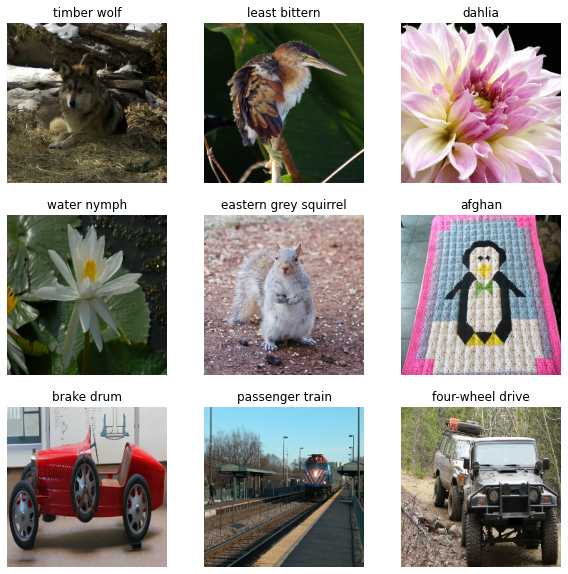

In [6]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds_preprocessed.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
import tensorflow as tf

class DualStream_CNN(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True):
        super().__init__()
        self.n_outputs =  n_outputs

        self.magno_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        
        self.parvo_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        avg_outputs = self.avg([p_stream,m_stream])
        return self.fc(avg_outputs)

In [9]:
FREEZE = False #One of None or imagenet
dual_stream_model = DualStream_CNN(50,batch_size,FREEZE)
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
dual_stream_model.summary()

In [ ]:
train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data = val_ds_preprocessed, epochs= 100)

In [12]:
dual_stream_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet/assets


### Exploring different types of architecture:

In [ ]:
#VGG architecture with no pre-loaded weights

out_classes = 10

Magno_VGG_16 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

Parvo_VGG_8 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

fc_end = Sequential([
    Average(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=out_classes, activation="softmax")
])

In [ ]:
EfficientModel = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

21848064/21834768 [==============================] - 1s 0us/step


In [ ]:
EfficientModel.layers